In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
import models
import generation_utils
import metrics_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint

In [199]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [4]:
device = torch.device('cuda')

In [5]:
base_path = '../models/base_24_2^18/'

In [6]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/base_24_2^18/checkpoints/730000_0.1004.pt


In [7]:
args = checkpoint['args']

In [8]:
t = tokenizer.Tokenizer(base = args['data']['base'])

In [9]:
args.keys()

dict_keys(['data', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'multi_gpu', 'verbose', 'tokenizer'])

In [10]:
model = models.Factorizer(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Factorizer(
  (embedding): TransformerEmbedding(
    (embedding): Embedding(28, 128)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.05, inplace=False)
          (dropout2): Dropout(p=0.05, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            

# Visualize Embeddings

In [11]:
embeddings = model.embedding.embedding.weight.data.cpu().numpy()

In [12]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(['x', '_', '>', '.'])
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [13]:
embeddings.shape

(28, 128)

In [14]:
tokens.shape

(28,)

In [15]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'x', '_', '.', '>'], dtype='<U11')

## TSNE
* Doesn't seem to be super interesting

In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(perplexity=30, learning_rate=200, n_iter=1000)
embeddings_for_plot = tsne.fit_transform(embeddings)

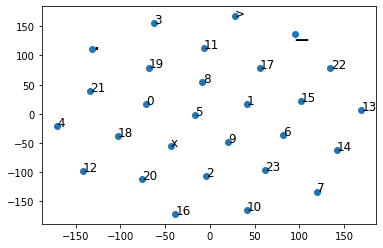

In [18]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    fontsize = 12 if not tok in ['.', '_'] else 24
    ax.annotate(tok, (x+.3,y), fontsize=fontsize)
plt.show()

## Cosine Similarity
* Some embeddings have relatively simlar cosine similarities

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
cs_sim_mat = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sim_mat, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

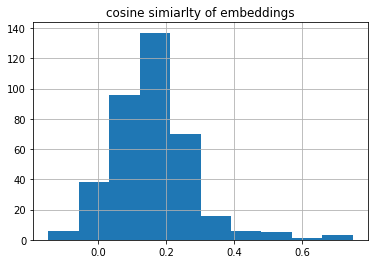

In [21]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

In [22]:
cs_sim_mat.shape

(28, 28)

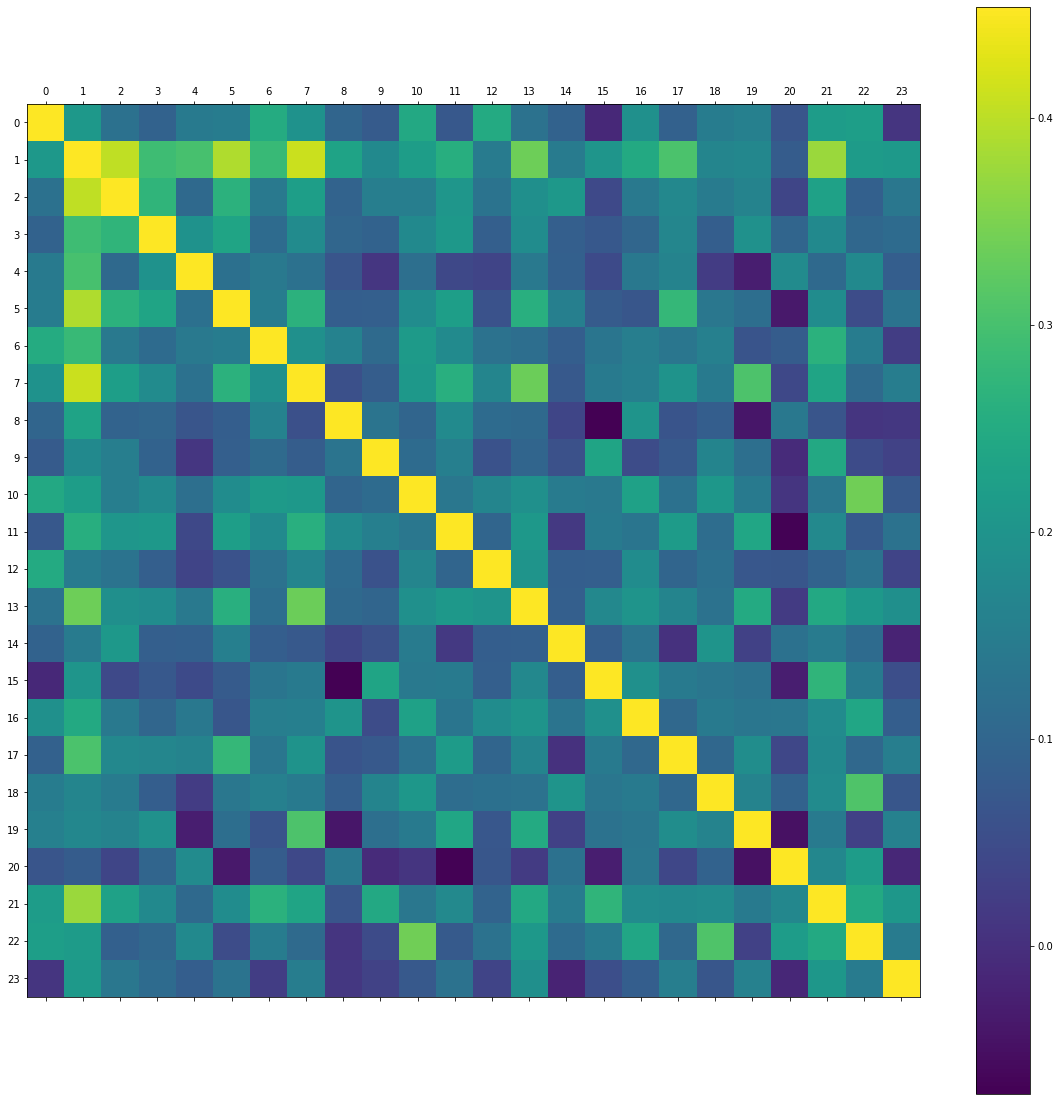

In [25]:
mat_show_mat = cs_sim_mat[:-4,:-4]

fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = plt.gca()
plt.colorbar(ax.matshow(np.clip(mat_show_mat, a_min=-1, a_max=mat_show_mat[mat_show_mat<.99].max()*1.1)), ax=ax)
ax.set_xticks(np.arange(mat_show_mat.shape[0]))
ax.set_yticks(np.arange(mat_show_mat.shape[0]))
ax.set_xticklabels(tokens[:mat_show_mat.shape[0]])
ax.set_yticklabels(tokens[:mat_show_mat.shape[0]])
plt.show()

In [26]:
cs_sim_mat[cs_sim_mat<1].max()*1.1

1.0999999344348907

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [28]:
logreg = LogisticRegression(C = .1, penalty='l1', solver='liblinear')
# logreg = SVC()

In [29]:
embeddings.shape, tokens.shape

((28, 128), (28,))

In [30]:
logreg_x = embeddings[:-4]
logreg_y = tokens[:-4].astype(int) % 2

In [31]:
train_indexer = np.random.rand(logreg_x.shape[0]) < .8
logreg_x_train = logreg_x[train_indexer]
logreg_x_test = logreg_x[~train_indexer]

logreg_y_train = logreg_y[train_indexer]
logreg_y_test = logreg_y[~train_indexer]

In [32]:
logreg_x_train.shape, logreg_y_train.shape

((23, 128), (23,))

In [33]:
logreg_x_test.shape, logreg_y_test.shape

((1, 128), (1,))

In [34]:
logreg.fit(logreg_x_train, logreg_y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [35]:
logreg.score(logreg_x_test, logreg_y_test)

0.0

# How well does the model do on numbers higher than what it was trained on?

In [54]:
start = 2**18
length = 100
numbers = np.arange(start, start + length)

In [55]:
import importlib
importlib.reload(metrics_utils)
importlib.reload(generation_utils)

<module 'generation_utils' from '../src\\generation_utils.py'>

In [56]:
t

In [57]:
larger_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], numbers, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [58]:
larger_df.shape

(10000, 7)

In [59]:
larger_df.head(5)

,target_num,beam_idx,log_prob,pred_factor_list,product,correct_product,correct_factorization
0,262144,0,-2.732651,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 107]",219136,False,False
1,262144,1,-2.737670,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 11, 11]",247808,False,False
2,262144,2,-2.973492,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5]",256000,False,False
3,262144,3,-3.054171,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 13]",186368,False,False
4,262144,4,-3.356747,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 17]",243712,False,False


In [60]:
larger_df.groupby('target_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.611
dtype: float64

In [61]:
top_beams = larger_df['beam_idx'] == 9
(larger_df[top_beams]['product'] < larger_df[top_beams]['target_num']).mean()

0.519

In [62]:
generation_utils.factor

<function generation_utils.factor(number, base, model, tokenizer, device, max_decode_size, n_beams=1, temperature=1.0, return_type='df', postprocess_minimal=False)>

In [63]:
from sympy import factorint
from sympy.ntheory import primerange

In [64]:
np.array(list(primerange(2, 10)))**2

array([ 4,  9, 25, 49], dtype=int32)

In [65]:
test_num = 1223*1223

In [66]:
factorint(test_num)

{1223: 2}

In [197]:
np.log(448451)/np.log(2)

18.774590832114356

In [207]:
import Levenshtein

In [211]:
num_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], np.array([444841]), args['model_args']['max_decode_size'], postprocess_minimal=False, n_beams = 10)
num_df['lev_dist'] = num_df.apply(lambda x: Levenshtein.distance(x['pred_str'].replace(' _', ''), x['target_str']), axis=1)
num_df

,target_num,beam_idx,log_prob,pred_factor_list,product,correct_product,correct_factorization,target_is_prime,input_string,pred_list,pred_str,target_str,target_factor_list,n_target_factors,n_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,pred_same_as_target,min_target_prime_factor_if_composite,lev_dist
0,444841,0,-2.526956,[60001],60001,False,False,True,"[1, 8, 4, 7, 1]","[[4, 8, 4, 1]]",> 4 8 4 1 . _ _ _ _ _ _,> 1 8 4 7 1 .,[444841],1,1,0,0.0,False,-1,3
1,444841,1,-3.367818,[60007],60007,False,False,True,"[1, 8, 4, 7, 1]","[[4, 8, 4, 7]]",> 4 8 4 7 . _ _ _ _ _ _,> 1 8 4 7 1 .,[444841],1,1,0,0.0,False,-1,3
2,444841,2,-4.399067,[239713],239713,False,False,True,"[1, 8, 4, 7, 1]","[[17, 8, 4, 1]]",> 17 8 4 1 . _ _ _ _ _ _,> 1 8 4 7 1 .,[444841],1,1,1,1.0,False,-1,3
3,444841,3,-4.577717,[239719],239719,False,False,True,"[1, 8, 4, 7, 1]","[[17, 8, 4, 7]]",> 17 8 4 7 . _ _ _ _ _ _,> 1 8 4 7 1 .,[444841],1,1,0,0.0,False,-1,3
4,444841,4,-5.635875,"[5, 29, 673]",97585,False,False,True,"[1, 8, 4, 7, 1]","[[5], [1, 5], [1, 4, 1]]",> 5 x 1 5 x 1 4 1 . _ _,> 1 8 4 7 1 .,[444841],1,3,3,1.0,False,-1,9
5,444841,5,-5.928322,"[5, 43, 353]",75895,False,False,True,"[1, 8, 4, 7, 1]","[[5], [1, 19], [14, 17]]",> 5 x 1 19 x 14 17 . _ _ _,> 1 8 4 7 1 .,[444841],1,3,3,1.0,False,-1,10
6,444841,6,-6.758257,"[5, 5, 7, 7, 83]",101675,False,False,True,"[1, 8, 4, 7, 1]","[[5], [5], [7], [7], [3, 11]]",> 5 x 5 x 7 x 7 x 3 11 .,> 1 8 4 7 1 .,[444841],1,5,5,1.0,False,-1,14
7,444841,7,-6.775347,"[5, 43, 311]",66865,False,False,True,"[1, 8, 4, 7, 1]","[[5], [1, 19], [12, 23]]",> 5 x 1 19 x 12 23 . _ _ _,> 1 8 4 7 1 .,[444841],1,3,3,1.0,False,-1,11
8,444841,8,-7.171434,"[5, 5, 5, 5, 97]",60625,False,False,True,"[1, 8, 4, 7, 1]","[[5], [5], [5], [5], [4, 1]]",> 5 x 5 x 5 x 5 x 4 1 .,> 1 8 4 7 1 .,[444841],1,5,5,1.0,False,-1,14
9,444841,9,-8.371604,"[5, 5, 5, 701]",87625,False,False,True,"[1, 8, 4, 7, 1]","[[5], [5], [5], [1, 5, 5]]",> 5 x 5 x 5 x 1 5 5 . _,> 1 8 4 7 1 .,[444841],1,4,4,1.0,False,-1,12


### how does it handle squares/cubes/...?

In [72]:
max_num = 256
squares = np.array(list(primerange(2, max_num)))**2
cubes = np.array(list(primerange(2, max_num)))**3

In [73]:
square_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], squares, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [74]:
square_df[square_df['beam_idx']==0]['correct_factorization'].mean()

0.6296296296296297

In [75]:
cube_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], cubes, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [76]:
cube_df[cube_df['beam_idx']==0]['correct_factorization'].mean()

0.18518518518518517

### When encoding two different numbers, what are the cosine similarities of their representations?

In [200]:
first_int = 16
second_int = 32

In [201]:
def get_reps_for_number(number):
    tokens = t.encode(data_utils.form_input(number, args['data']['base']))
    tens = torch.tensor(tokens).unsqueeze(0).to(device)
    memory, _ = model.encode(tens)
    return memory.squeeze().data.cpu().numpy(), tokens

In [202]:
first_reps, first_tokens = get_reps_for_number(first_int)
second_reps, second_tokens = get_reps_for_number(second_int)

In [203]:
cs_sims = cosine_similarity(first_reps, second_reps)

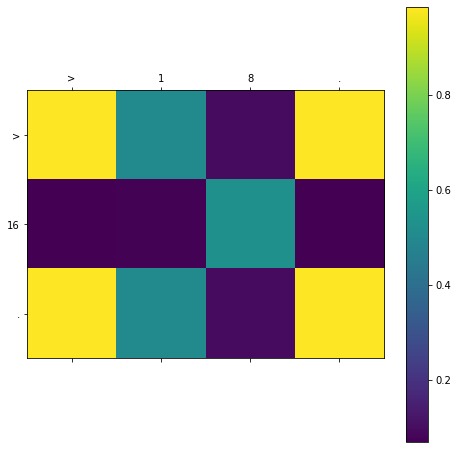

In [204]:
fig = plt.gcf()
fig.set_size_inches(8,8)
ax = plt.gca()
plt.colorbar(ax.matshow(cs_sims), ax=ax)
ax.set_xticks(np.arange(cs_sims.shape[1]))
ax.set_yticks(np.arange(cs_sims.shape[0]))
ax.set_xticklabels(t.decode(second_tokens, decode_special=True).split(' '))
ax.set_yticklabels(t.decode(first_tokens, decode_special=True).split(' '))
plt.show()

# When the model gets it wrong, what is the probability of the right sequence?

In [276]:
target_num = 277337

In [277]:
num_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], np.array([target_num]), args['model_args']['max_decode_size'], postprocess_minimal=False, n_beams = 10)
num_df['lev_dist'] = num_df.apply(lambda x: Levenshtein.distance(x['pred_str'].replace(' _', ''), x['target_str']), axis=1)
num_df

,target_num,beam_idx,log_prob,pred_factor_list,product,correct_product,correct_factorization,target_is_prime,input_string,pred_list,pred_str,target_str,target_factor_list,n_target_factors,n_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,pred_same_as_target,min_target_prime_factor_if_composite,lev_dist
0,277337,0,-3.147279,"[5, 113, 341]",192665,False,False,False,"[20, 1, 11, 17]","[[5], [4, 17], [14, 5]]",> 5 x 4 17 x 14 5 . _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,3,2,0.666667,False,463,10
1,277337,1,-3.211429,"[5, 107, 527]",281945,False,False,False,"[20, 1, 11, 17]","[[5], [4, 11], [21, 23]]",> 5 x 4 11 x 21 23 . _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,3,2,0.666667,False,463,9
2,277337,2,-3.589801,"[5, 101, 401]",202505,False,False,False,"[20, 1, 11, 17]","[[5], [4, 5], [16, 17]]",> 5 x 4 5 x 16 17 . _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,3,3,1.000000,False,463,10
3,277337,3,-3.629195,"[5, 97, 421]",204185,False,False,False,"[20, 1, 11, 17]","[[5], [4, 1], [17, 13]]",> 5 x 4 1 x 17 13 . _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,3,3,1.000000,False,463,9
4,277337,4,-3.711498,"[17, 15433]",262361,False,False,False,"[20, 1, 11, 17]","[[17], [1, 2, 19, 1]]",> 17 x 1 2 19 1 . _ _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,2,1,0.500000,False,463,7
5,277337,5,-3.869519,"[11, 43, 553]",261569,False,False,False,"[20, 1, 11, 17]","[[11], [1, 19], [23, 1]]",> 11 x 1 19 x 23 1 . _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,3,2,0.666667,False,463,7
6,277337,6,-3.960406,"[23, 11983]",275609,False,False,False,"[20, 1, 11, 17]","[[23], [20, 19, 7]]",> 23 x 20 19 7 . _ _ _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,2,1,0.500000,False,463,9
7,277337,7,-4.139458,"[5, 109, 553]",301385,False,False,False,"[20, 1, 11, 17]","[[5], [4, 13], [23, 1]]",> 5 x 4 13 x 23 1 . _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,3,2,0.666667,False,463,8
8,277337,8,-4.495574,"[5, 109, 457]",249065,False,False,False,"[20, 1, 11, 17]","[[5], [4, 13], [19, 1]]",> 5 x 4 13 x 19 1 . _ _,> 19 7 x 1 0 23 .,"[463, 599]",2,3,3,1.000000,False,463,10
9,277337,9,-5.240434,"[7, 7, 7, 743]",254849,False,False,False,"[20, 1, 11, 17]","[[7], [7], [7], [1, 6, 23]]",> 7 x 7 x 7 x 1 6 23 .,> 19 7 x 1 0 23 .,"[463, 599]",2,4,4,1.000000,False,463,8


In [278]:
data_utils.form_label(target_num, args['data']['base'])

['>', 19, 7, 'x', 1, 0, 23, '.']

In [279]:
def get_prob_of_factorization(number, factorization):
    tokens = t.encode(data_utils.form_input(number, args['data']['base']))
    tensor_input = torch.tensor(tokens).unsqueeze(0).to(device)
    
    factorization_input = torch.tensor(t.encode(factorization)).unsqueeze(0).to(device)
    
    model_output = torch.softmax(model(tensor_input, factorization_input).squeeze(0), dim=-1)
    
    probs = model_output[torch.arange(model_output.size(0)-1),factorization_input[0,1:]]
    
    return probs.log().sum()

In [280]:
get_prob_of_factorization(target_num, num_df.iloc[0]['target_str'].strip().split(' '))

tensor(-22.5835, device='cuda:0', grad_fn=<SumBackward0>)